In [1]:
import math
import random
from statistics import median

import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy.ma.core import repeat

from src.mst.pamst import pamst, comp_mst_weight
from src.mst.mst_utilities import compute_real_mst_weight, generate_random_complete_graph, compute_input_perturbation

sns.set_theme(font_scale=1.5, rc={'text.usetex' : True})



In [63]:
# Computing Private Minimum Spanning Trees using Different Algorithms, Using l_infty neighboroing relationsip

# Privacy Parameters
#rho_values = [0.1,0.015,0.2,0.375,0.5,1,2,4,6,10, 100, 200]
rho_values = np.arange(0.00001, 10, 0.005)
repeats = 1 # TODO implement to get more data,.
n = 100
sensitivity = 1

# Generate a enw graph
G = generate_random_complete_graph(n)
print("Generated " + str(G))

### Real Spanning Tree ###

    # Simply make an array to make visualization easier
real_weights = [compute_real_mst_weight(G)] * len(rho_values) 
print("Real MST Weight: " + str(real_weights[0]))

### Pinot's PAMST Algorithm ###

pamst_weights = []
for rho in rho_values:
    noise_level = (2 * sensitivity * math.sqrt( (n-1)/(2 * rho))) # Should be ok
    pamst_edges = pamst(G, noise_level) # Gives an iterator which should only be executed once!
    pamst_weights += [comp_mst_weight(pamst_edges)]
#    print("PAMST MST Weight: " + str(pamst_weight))


### Sealfon's Post Processing Technique ###

sealfon_weights = []
for rho in rho_values:
    noise_level = n / (2*rho)
    gaussNoise = lambda edge_weight: edge_weight + np.random.normal(0, noise_level)
    sealfon_weights += [compute_input_perturbation(G.copy(), gaussNoise)]
    # print("Sealfon MST Weight: " + str(weight_sealfon))
print(sealfon_weights)

### Finally: Our Approach ###
our_weights = []
for rho in rho_values:
    noise_level = sensitivity * math.sqrt(2*rho) / 2 * (n-1)
    # expNoise = lambda edge_weight: (math.log(np.random.exponential(1), math.e) + noise_level * edge_weight)
    expNoise = lambda edge_weight: (np.random.exponential(1) / np.exp(-noise_level * edge_weight))

    #    expNoise = lambda noise_level, weight: 0
    our_weights += [compute_input_perturbation(G.copy(), expNoise)]
    # print("Our MST Weight: " + str(weight_sealfon))

print(sealfon_weights)


## TODO Privacy / utility Tradeoff Curves.
## TODO Select Graph Classes we want to do experiments on.

Generated Graph with 100 nodes and 4950 edges
Real MST Weight: 1.0404191429891512


KeyboardInterrupt: 

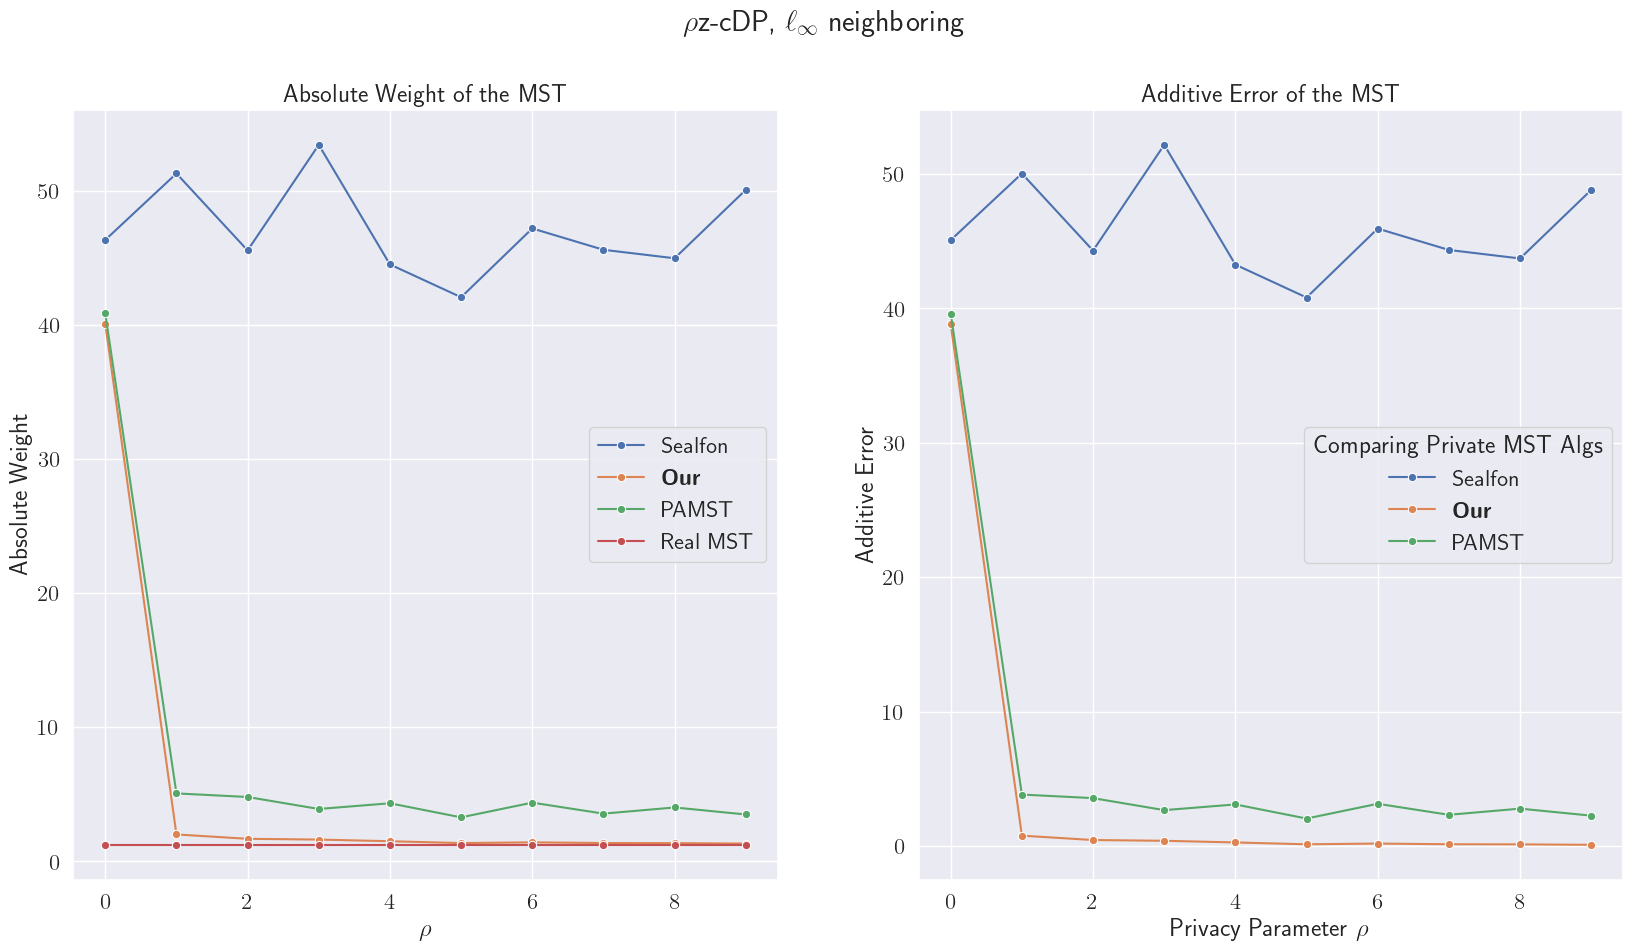

In [62]:
# Visualizing the results, Complete Graph

fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # 2x2 grid
fig.suptitle("$\\rho $z-cDP, $\\ell_\\infty$ neighboring")

# Error of the MST
sns.lineplot(x= rho_values, y=sealfon_weights,marker='o', label="Sealfon", ax=axs[0])
sns.lineplot(x= rho_values, y=our_weights, marker='o', label="$\\textbf{Our}$", ax=axs[0])
sns.lineplot(x= rho_values, y=pamst_weights, marker='o', label="PAMST", ax=axs[0])
sns.lineplot(x= rho_values, y=real_weights, marker='o', label="Real MST", ax=axs[0])
axs[0].set_title("Absolute Weight of the MST")

# Error of the MST
sns.lineplot(x= rho_values, y=[sealfon - real for sealfon, real in zip(sealfon_weights, real_weights)] ,marker='o', label="Sealfon", ax=axs[1])
sns.lineplot(x= rho_values, y=[ours - real for ours, real in zip(our_weights, real_weights)] , marker='o', label="$\\textbf{Our}$", ax=axs[1])
sns.lineplot(x= rho_values, y=[pamst - real for pamst, real in zip(pamst_weights, real_weights)] , marker='o', label="PAMST", ax=axs[1])
axs[1].set_title("Additive Error of the MST")
axs[0].set_ylabel("Absolute Weight")
axs[0].set_xlabel("$\\rho$")
axs[1].set_ylabel("Additive Error")

# Set plot title and labels
# plt.title("Real MSTs")
plt.xlabel("Privacy Parameter $\\rho$")
# plt.ylabel("MST Weight")
plt.legend(title = "Comparing Private MST Algs")
plt.show()
